In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=4b33b99e60058523a32da9e1104b43fa31173f795dbc36066f3cdd8309424673
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,mean, count
from pyspark.sql.types import *

In [11]:
data_path = "/content/drive/MyDrive/AmazonReviews/"
review_file_mapping = {"giftcards": "amazon_reviews_us_Gift_Card_v1_00.tsv",
                       "personal_care_appliances": "amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv",
                       "mobile_electronics": "amazon_reviews_us_Mobile_Electronics_v1_00.tsv",
                       "major_appliances": "amazon_reviews_us_Major_Appliances_v1_00.tsv",
                       "digital_video_games": "amazon_reviews_us_Digital_Video_Games_v1_00.tsv",
                       "digital_software": "amazon_reviews_us_Digital_Software_v1_00.tsv"
                      #  "apparel": "amazon_reviews_us_Apparel_v1_00.tsv",
                      #  "baby": "amazon_reviews_us_Baby_v1_00.tsv",
                      #  "camera": "amazon_reviews_us_Camera_v1_00.tsv",
                      #  "tools": "amazon_reviews_us_Tools_v1_00.tsv",
                      #  "pet_products": "amazon_reviews_us_Pet_Products_v1_00.tsv",
                      #  "tools": "amazon_reviews_us_Tools_v1_00.tsv"
                       }

spark = SparkSession.builder \
    .appName("Analyse Reviews") \
    .config("spark.executor.memory","2g") \
    .config("spark.executor.cores","1") \
    .master("local[*]") \
    .getOrCreate()

In [14]:
schema = StructType([
     StructField("marketplace", StringType(), True),
    StructField("customer_id", LongType(), True),
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", LongType(), True),
    StructField("helpful_votes", LongType(), True),
    StructField("total_votes", LongType(), True),
    StructField("vine", StringType(), True),
    StructField("verified_purchase", StringType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", StringType(), True)
])
df = spark.createDataFrame([], schema)
for file in review_file_mapping:
    file_df = spark.read.csv(data_path + review_file_mapping[file], schema=schema, sep="\t", header=True).sample(fraction=0.2)
    df = df.union(file_df)
#file_path = data_path + review_file_mapping["giftcards"]
#df = spark.read.csv(file_path, schema=schema, sep="\t", header=True)
df.count()

137428

# Preprocessing Amazon Customer Reviews Dataset

In this section, we discuss the preprocessing steps applied to the Amazon customer reviews dataset. This preprocessing is essential for ensuring the quality and consistency of the data before any exploratory data analysis (EDA) or further processing.
### 1. Data Validation and Cleaning

The initial steps involve validating and cleaning various fields in the dataset.

- **Integer Fields Validation**: We validate fields like 'customer_id', 'star_rating', 'helpful_votes', and 'total_votes'. The validation checks include ensuring these fields are not null and casting them to long integers where necessary. This ensures that numerical data is correctly formatted and free from null values.

- **String Fields Validation**: We validate string fields like 'product_id', 'marketplace', 'review_id', 'product_parent', 'product_title', 'product_category', 'review_headline', and 'review_body'. The validation involves checking for non-null and non-empty values. This step is critical to ensure that key textual information is available for each review.

- **Date Field Validation**: The 'review_date' field is validated to ensure it follows the format 'YYYY-MM-DD'. Proper date formatting is vital for any temporal analysis.

- **Predefined Values Validation**: Fields such as 'vine' and 'verified_purchase' are checked to contain only predefined values ('Y' or 'N'). This standardizes the values for these binary indicators.

### 2. ASCII Check for String Fields

**ASCII Character Check**: For certain string fields, there is an additional validation to ensure they contain only ASCII characters. This can be important for consistency in text processing and to avoid issues with character encoding.

### 3. Lowercasing Text Fields

**Lowercasing Fields**: The 'product_title', 'review_headline', and 'review_body' fields are converted to lowercase. This standardizes the text, making it easier to handle in subsequent text analysis and reducing the complexity caused by case sensitivity.

In [15]:
from pyspark.sql.functions import col, lower, when, regexp_replace, to_date, coalesce, lit, mean, count

def preprocess(df):
    def is_ascii(column):
       return col(column).rlike("^[\\x00-\\x7F]*$")

    # Validate integer fields
    df = df.filter(col('customer_id').isNotNull() & col('customer_id').cast("long").isNotNull())
    df = df.filter(col('star_rating').isNotNull() & (col('star_rating') >= 1) & (col('star_rating') <= 5))
    df = df.filter(col('helpful_votes').isNotNull() & col('helpful_votes').cast("long").isNotNull())
    df = df.filter(col('total_votes').isNotNull() & col('total_votes').cast("long").isNotNull())
    # Validate string fields
    df = df.filter(col('product_id').isNotNull() & (col('product_id') != ""))
    df = df.filter(col('marketplace').isNotNull() & (col('marketplace') != ""))
    df = df.filter(col('review_id').isNotNull() & (col('review_id') != ""))
    df = df.filter(col('product_parent').isNotNull() & (col('product_parent') != ""))
    df = df.filter(col('product_title').isNotNull() & (col('product_title') != ""))
    df = df.filter(col('product_category').isNotNull() & (col('product_category') != ""))
    df = df.filter(col('review_headline').isNotNull() & (col('review_headline') != ""))
    df = df.filter(col('review_body').isNotNull() & (col('review_body') != ""))
    # Validate review_date format (assuming format "YYYY-MM-DD")
    df = df.filter(col('review_date').rlike("^\d{4}-\d{2}-\d{2}$"))
    # Validate specific fields with predefined values
    df = df.filter(col('vine').isin(['Y', 'N']))
    df = df.filter(col('verified_purchase').isin(['Y', 'N']))
    print(df.count())
    # Validate string fields for non-null, non-empty, and ASCII characters
    string_fields = ['marketplace', 'review_id', 'product_parent', 'product_title',
                'product_category', 'review_headline', 'review_body', 'vine', 'verified_purchase']
    for field in string_fields:
        df = df.filter((col(field) != "") & is_ascii(field))
    print(df.count())
    df = df.withColumn('product_title', lower(col('product_title')))
    df = df.withColumn('review_headline', lower(col('review_headline')))
    df = df.withColumn('review_body', lower(col('review_body')))

    return df

df = preprocess(df)
df.head()

137424
133890


Row(marketplace='US', customer_id=861463, review_id='R1HVYBSKLQJI5S', product_id='B00IX1I3G6', product_parent='926539283', product_title='amazon.com gift card balance reload', product_category='Gift Card', star_rating=5, helpful_votes=0, total_votes=0, vine='N', verified_purchase='Y', review_headline='five stars', review_body='good', review_date='2015-08-31')

In [ ]:
df.describe().show()

# Analysis of Amazon Customer Reviews Dataset
In this section, we delve into specific analyses performed on the Amazon customer reviews dataset.


In [ ]:
avg_star_rating = df.select(mean(col("star_rating"))).show()

reviews_per_category = df.groupBy("product_category").count().show()

avg_helpful_votes_per_rating = df.groupBy("star_rating").agg(mean(col("helpful_votes"))).show()

+-----------------+
| avg(star_rating)|
+-----------------+
|3.981808888087077|
+-----------------+

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|           Gift Card|29435|
|Personal_Care_App...|16137|
|  Mobile_Electronics|19778|
|    Major Appliances|18925|
| Digital_Video_Games|28699|
|    Digital_Software|20058|
+--------------------+-----+

+-----------+------------------+
|star_rating|avg(helpful_votes)|
+-----------+------------------+
|          5|1.3203068899051362|
|          1| 4.130720274775229|
|          3|2.1383156720580034|
|          2| 3.069057895520167|
|          4|1.8903318109283003|
+-----------+------------------+



**Visual Representation of Review Distribution**: The following plot provides a visual representation of the number of reviews each product category has received. It showcases which categories are more frequently reviewed by customers, indicating higher engagement or interest in those categories.
**Market Trend Analysis**: The distribution of reviews can also provide insights into market trends. For instance, if a previously niche category shows a significant increase in the number of reviews, it might indicate a rising trend in that market segment.

<Figure size 1200x600 with 0 Axes>

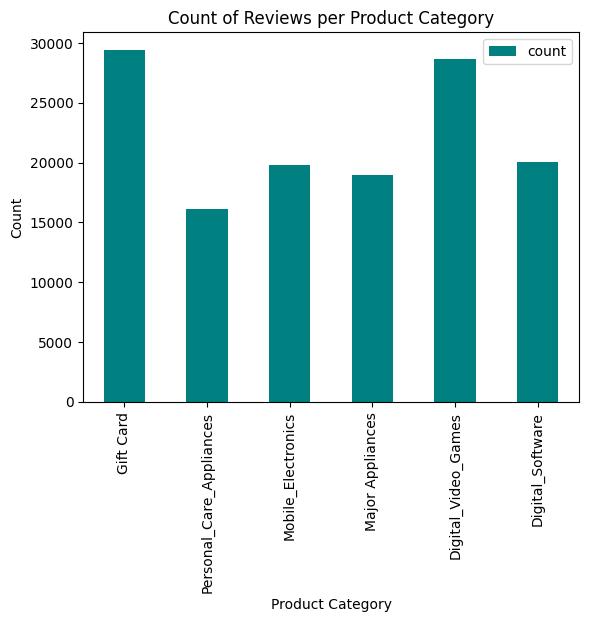

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.toPandas()
pdf_reviews_per_category = df.groupBy("product_category").count().toPandas()

plt.figure(figsize=(12, 6))
pdf_reviews_per_category.plot(kind='bar', x='product_category', y='count', color='teal')
plt.title('Count of Reviews per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
#plt.xticks(rotation=45)
plt.show()

**Customer Behavior Analysis**: This analysis can offer insights into customer behavior, such as whether customers find critical reviews (lower star ratings) more helpful than positive reviews (higher star ratings) or vice versa.
**Guidance for Reviewers**: This plot can also inform potential reviewers about the type of content that is valued by the Amazon community, based on which ratings receive more helpful votes.

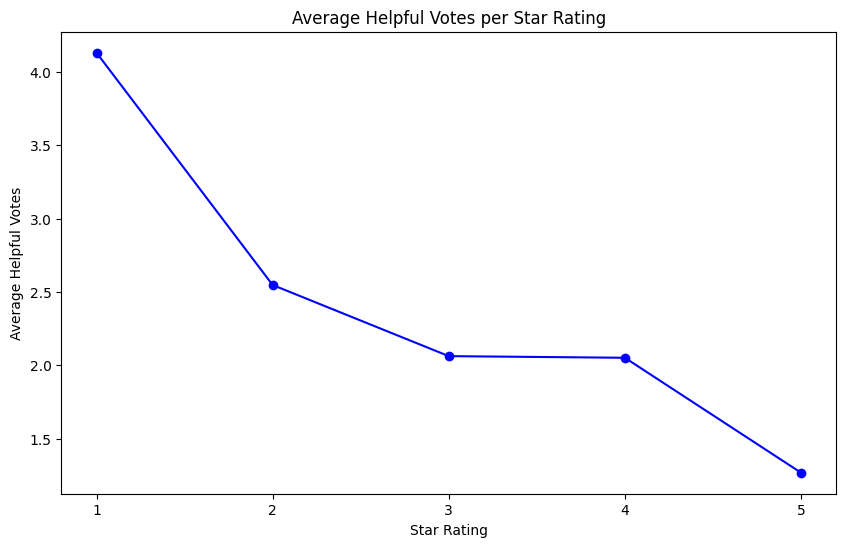

In [ ]:
pdf_avg_helpful_votes_per_rating = df.groupBy("star_rating")\
                                     .agg(mean(col("helpful_votes")))\
                                     .orderBy("star_rating")\
                                     .toPandas()

plt.figure(figsize=(10, 6))
plt.plot(pdf_avg_helpful_votes_per_rating['star_rating'], pdf_avg_helpful_votes_per_rating['avg(helpful_votes)'], marker='o', color='blue')
plt.title('Average Helpful Votes per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')
plt.xticks(range(1, 6))
plt.show()

**Identifying Helpfulness Trends**: This analysis aims to identify trends in how often reviews with different star ratings are flagged as helpful by other customers.

**Understanding Customer Perception**: The percentage of helpful reviews per star rating provides insights into customer perceptions regarding the usefulness of reviews at different rating levels.

**Decision Making for Customers**: For potential buyers, understanding which star ratings have more helpful reviews can guide them in making more informed purchasing decisions based on the most trusted reviews.


In [ ]:
from pyspark.sql.functions import sum as _sum

df_with_helpful_flag = df.withColumn("is_helpful", (col("helpful_votes") > 0).cast("integer"))

helpful_percentage_per_rating = df_with_helpful_flag.groupBy("star_rating").agg(
    (_sum("is_helpful") / count("*") * 100).alias("helpful_percentage")
).orderBy("star_rating")

helpful_percentage_per_rating.show()

+-----------+------------------+
|star_rating|helpful_percentage|
+-----------+------------------+
|          1|57.830584861210696|
|          2| 47.02932685002279|
|          3|38.192451997351576|
|          4| 31.99978138492649|
|          5| 21.35065908664959|
+-----------+------------------+



<Figure size 1000x600 with 0 Axes>

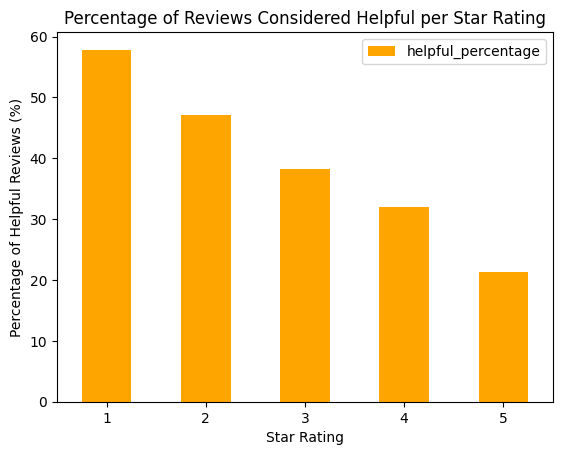

In [ ]:
pdf_helpful_percentage = helpful_percentage_per_rating.toPandas()

plt.figure(figsize=(10, 6))
pdf_helpful_percentage.plot(kind='bar', x='star_rating', y='helpful_percentage', color='orange')
plt.title('Percentage of Reviews Considered Helpful per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Percentage of Helpful Reviews (%)')
plt.xticks(rotation=0)
plt.show()

**Visualizing Review Trends Over Time**: The primary aim of this plot is to visualize how the volume of reviews has changed over the years. It helps in identifying any temporal patterns, trends, or seasonal variations in the number of reviews.
  
**Identifying Seasonal Trends**: This visualization can reveal seasonal trends in customer review activity, such as increased reviews during holiday seasons or sales events.

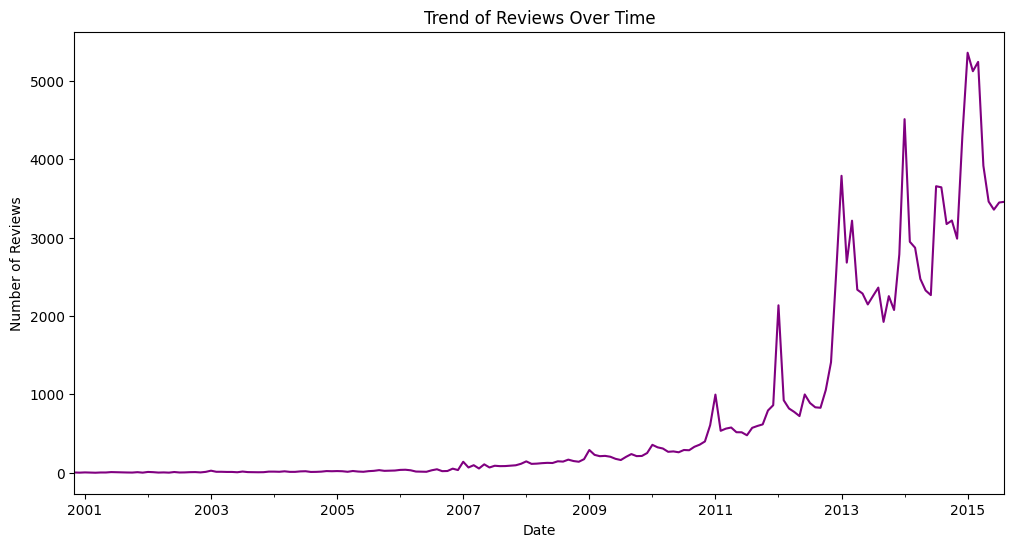

In [ ]:
pdf['review_date'] = pd.to_datetime(pdf['review_date'], errors='coerce', format='%Y-%m-%d')

# Drop rows where review_date is NaT (Not a Time) due to conversion errors
pdf = pdf.dropna(subset=['review_date'])

pdf.set_index('review_date', inplace=True)

monthly_reviews = pdf.resample('M').size()

plt.figure(figsize=(12, 6))
monthly_reviews.plot(color='purple')
plt.title('Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

**Word Count Analysis**: This histogram illustrates the distribution of the number of words per review, providing insight into the typical length of customer feedback.

**Identifying Common Review Lengths**: By showing the count of reviews at different word count intervals, we can identify the most common lengths of reviews customers write.

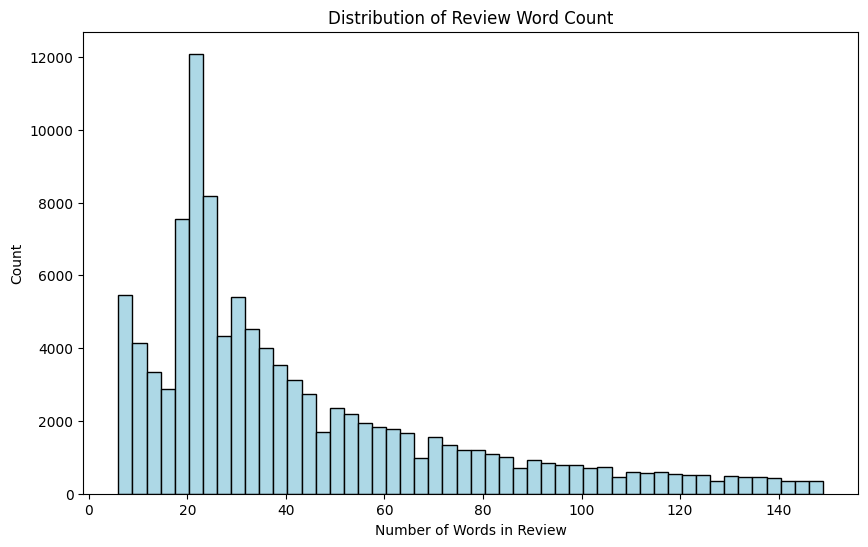

In [ ]:
pdf['review_word_count'] = pdf['review_body'].str.split().apply(lambda x: len(x) if x is not None else 0)

filtered_pdf = pdf[(pdf['review_word_count'] > 5) & (pdf['review_word_count'] < 150)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_pdf['review_word_count'], bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Review Word Count')
plt.xlabel('Number of Words in Review')
plt.ylabel('Count')

plt.show()

**Correlation Analysis**: The heatmap provides a quick visual analysis of the correlations between variables like star rating, helpful votes, total votes, and review word count.

**Intensity of Relationships**: The color intensity represents the strength and direction of the correlation. Dark red indicates a strong positive correlation, dark blue indicates a strong negative correlation, and lighter colors suggest weaker relationships.

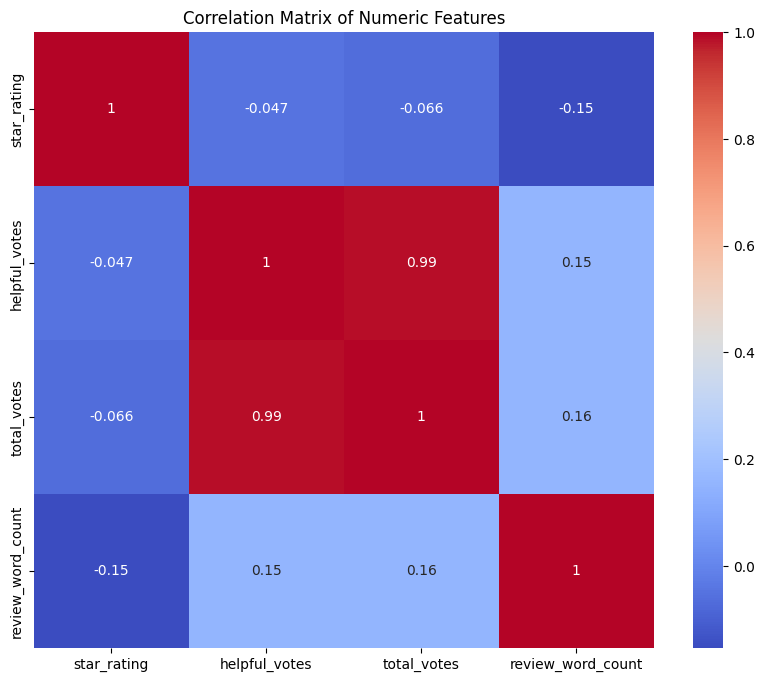

In [ ]:
import seaborn as sns

corr_matrix = pdf[['star_rating', 'helpful_votes', 'total_votes', 'review_word_count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

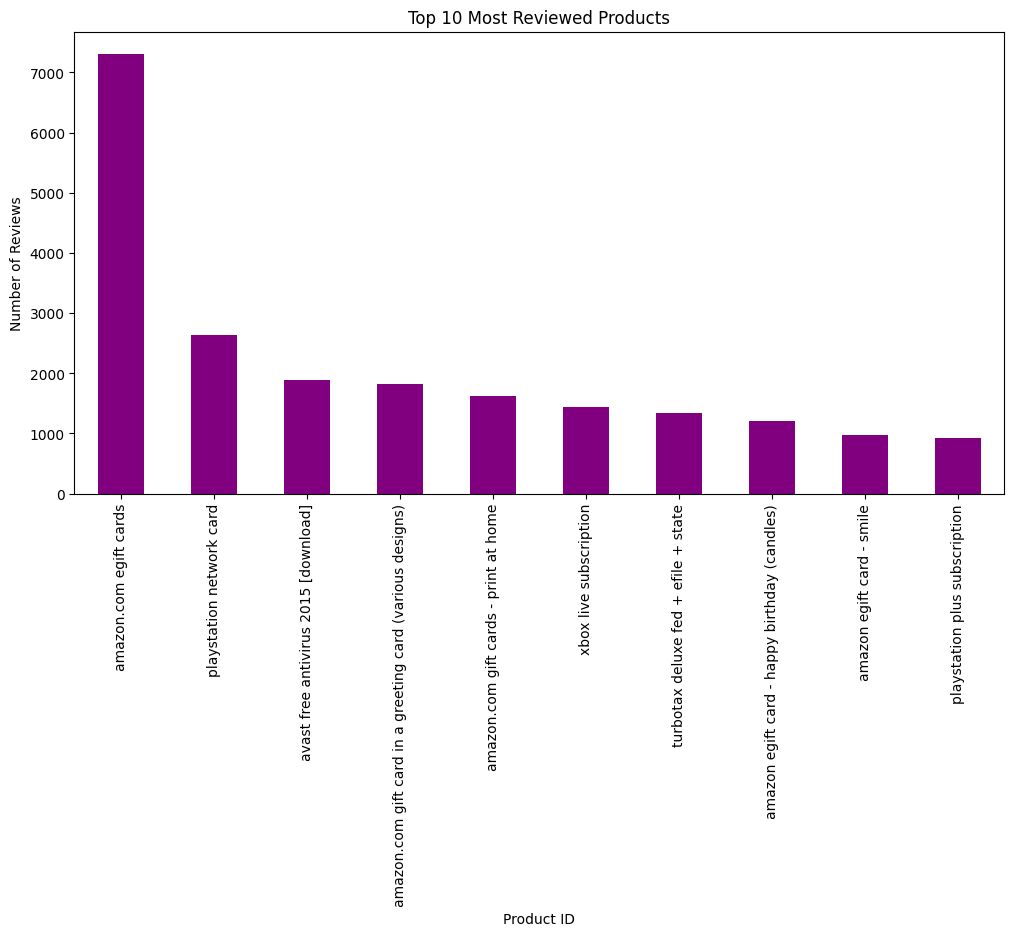

In [ ]:
reviews_per_product = pdf['product_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
reviews_per_product.plot(kind='bar', color='purple')
plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.show()

**Insight into Perceived Helpfulness**: This histogram specifically targets the analysis of how helpful a review is perceived by others, by measuring the proportion of helpful votes out of the total votes a review has received.

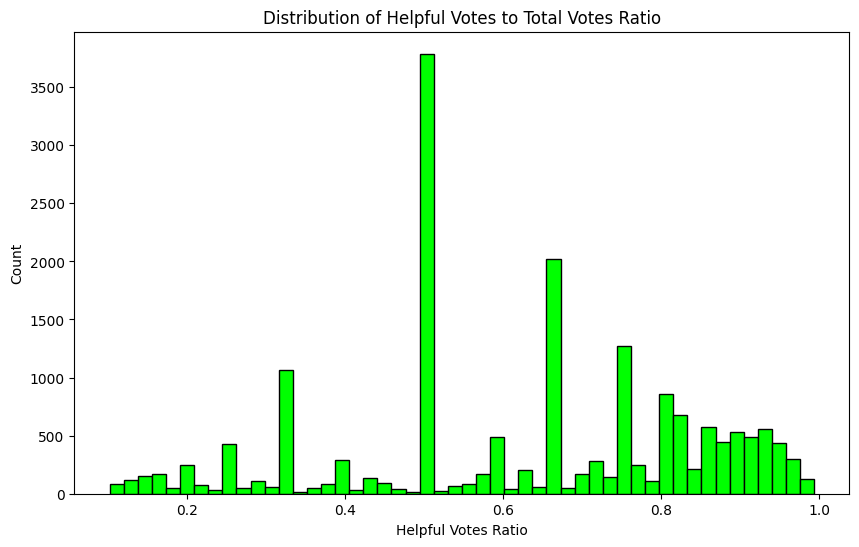

In [ ]:
pdf['helpful_ratio'] = pdf['helpful_votes'] / pdf['total_votes']
pdf['helpful_ratio'] = pdf['helpful_ratio'].fillna(0)

pdf_filtered = pdf[(pdf['helpful_ratio'] > 0.1) & (pdf['helpful_ratio'] < 1.0)]
plt.figure(figsize=(10, 6))
plt.hist(pdf_filtered['helpful_ratio'], bins=50, color='lime', edgecolor='black')
plt.title('Distribution of Helpful Votes to Total Votes Ratio')
plt.xlabel('Helpful Votes Ratio')
plt.ylabel('Count')
plt.show()

# Sentiment Analysis
The sentiment analysis for out dataset has been performed using VADER (Valence Aware Dictionary and sEntiment Reasoner)

- **Lexicon**: VADER has a lexicon of words and emoticons, each of which is assigned a numerical score indicating their sentiment valence. The valence scores range from extremely negative to extremely positive.
- **Rules**: VADER combines these scores with a set of heuristic rules to account for different factors, such as punctuation, degree modifiers, and conjunctives that may influence the sentiment intensity of phrases.

The code downloads the VADER lexicon then computes the sentiment scores based on the review_body column.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment_compound(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(text)['compound']

def get_sentiment_neutral(text):
    if pd.isna(text):
        return None
    return sia.polarity_scores(text)['neu']

pdf['sentiment_score'] = pdf['review_body'].apply(get_sentiment_compound)
pdf['neutral_score'] = pdf['review_body'].apply(get_sentiment_neutral)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Sentiment Assessment**: This analysis evaluates the sentiment conveyed in customer reviews for different star ratings. It aims to determine if higher star ratings generally correspond to more positive sentiment, and conversely, if lower star ratings align with more negative sentiment.

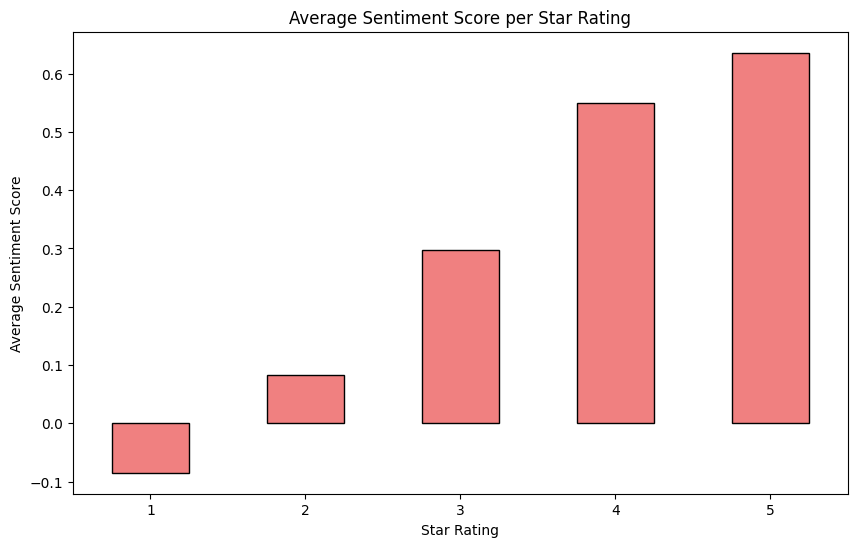

In [ ]:
avg_sentiment_per_rating = pdf.groupby('star_rating')['sentiment_score'].mean()

plt.figure(figsize=(10, 6))
avg_sentiment_per_rating.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Sentiment Score per Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()

**Sentiment Categorization**: The primary purpose of this analysis is to categorize customer sentiments into three groups: "Negative," "Neutral," and "Positive," based on sentiment scores.

/tmp/ipykernel_155154/673851844.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data_sentiment = pdf.groupby(['star_rating', 'sentiment_category']).agg({'sentiment_score': 'mean'}).reset_index()


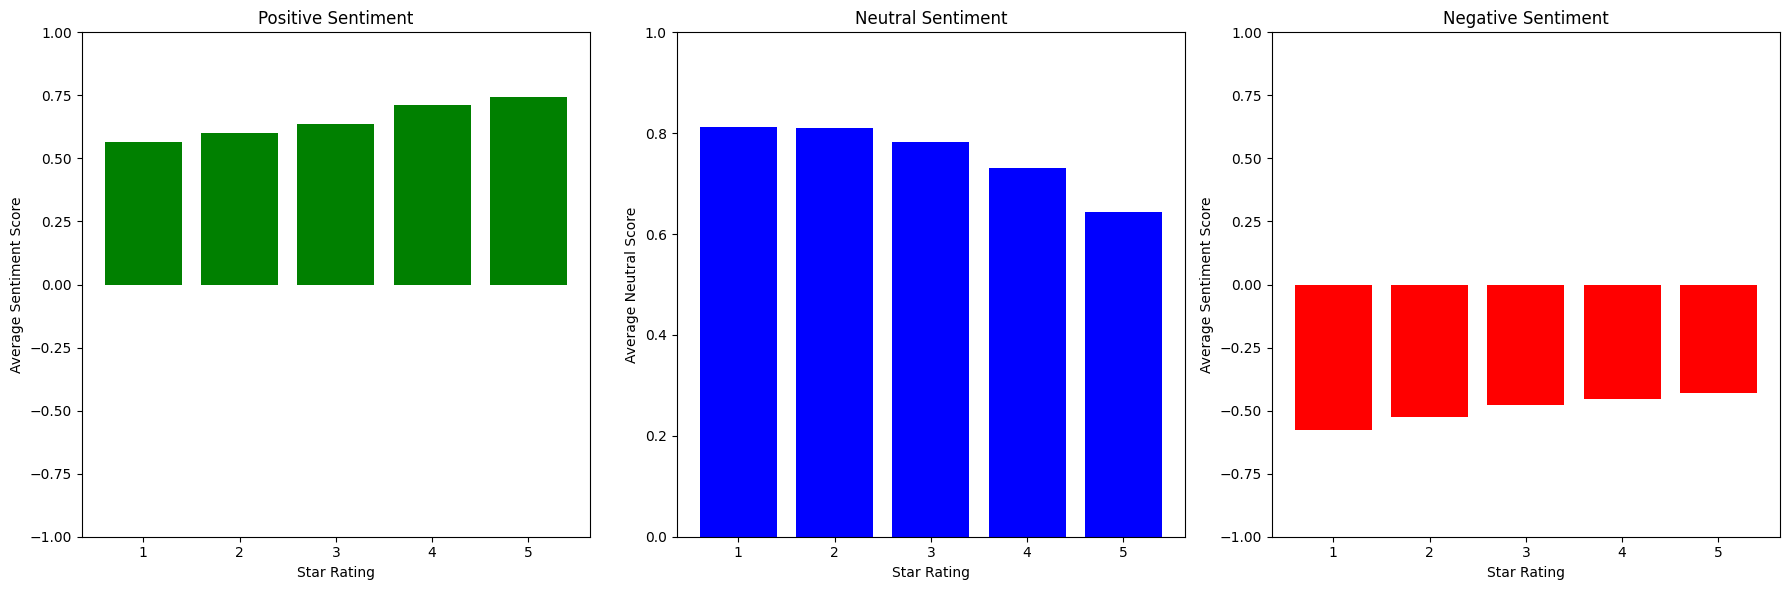

In [ ]:
pdf['sentiment_category'] = pd.cut(pdf['sentiment_score'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

grouped_data_sentiment = pdf.groupby(['star_rating', 'sentiment_category']).agg({'sentiment_score': 'mean'}).reset_index()

grouped_data_neutral = pdf.groupby('star_rating').agg({'neutral_score': 'mean'}).reset_index()

positive_data = grouped_data_sentiment[grouped_data_sentiment['sentiment_category'] == 'Positive']
negative_data = grouped_data_sentiment[grouped_data_sentiment['sentiment_category'] == 'Negative']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].bar(positive_data['star_rating'], positive_data['sentiment_score'], color='green')
axes[0].set_title('Positive Sentiment')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].set_ylim([-1, 1])

axes[1].bar(grouped_data_neutral['star_rating'], grouped_data_neutral['neutral_score'], color='blue')
axes[1].set_title('Neutral Sentiment')
axes[1].set_xlabel('Star Rating')
axes[1].set_ylabel('Average Neutral Score')
axes[1].set_ylim([0, 1])

#TODO: possibly reduce y axis values for negative plot
axes[2].bar(negative_data['star_rating'], negative_data['sentiment_score'], color='red')
axes[2].set_title('Negative Sentiment')
axes[2].set_xlabel('Star Rating')
axes[2].set_ylabel('Average Sentiment Score')
axes[2].set_ylim([-1, 1])

plt.tight_layout()
plt.show()

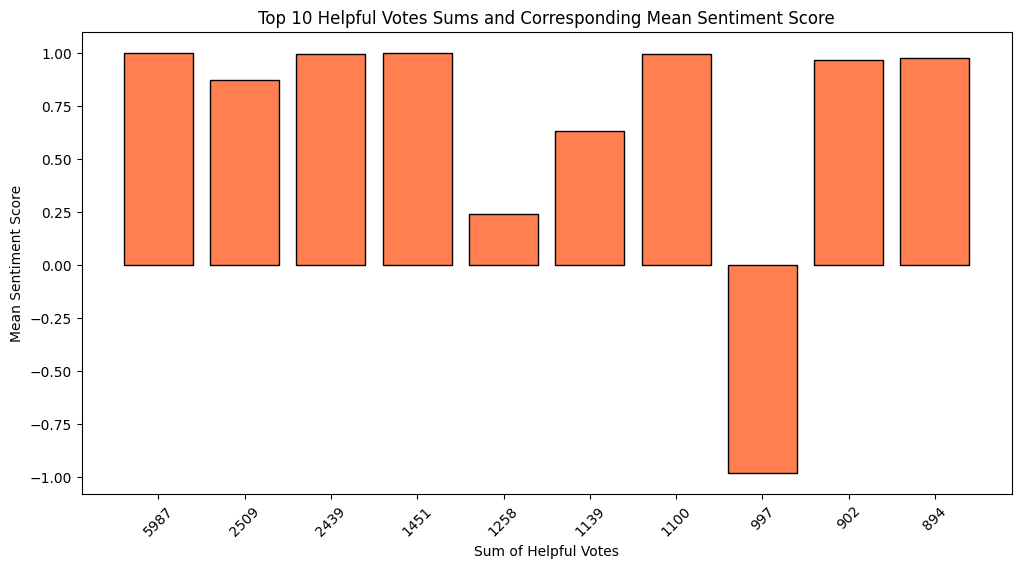

In [ ]:
customer_helpful_votes = pdf.groupby('customer_id').agg({'helpful_votes': 'sum', 'sentiment_score': 'mean'})

top_customers = customer_helpful_votes.sort_values(by='helpful_votes', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_customers['helpful_votes'].astype(str), top_customers['sentiment_score'], color='coral', edgecolor='black')
plt.title('Top 10 Helpful Votes Sums and Corresponding Mean Sentiment Score')
plt.xlabel('Sum of Helpful Votes')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=45)
plt.show()

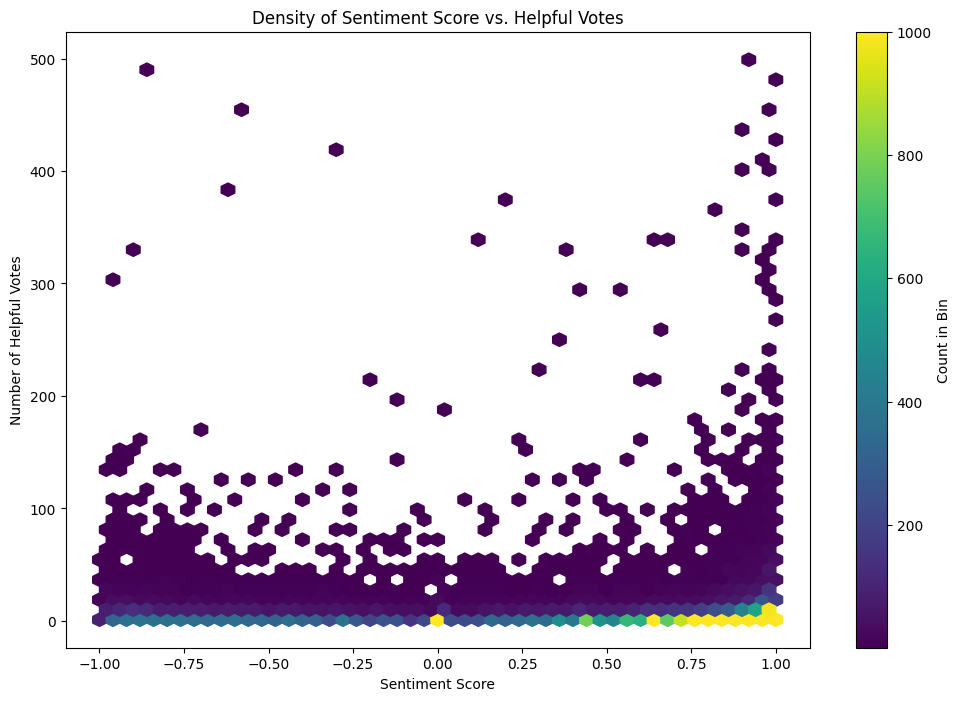

In [ ]:
median_sentiment = pdf['sentiment_score'].median()
std_dev_sentiment = pdf['sentiment_score'].std()
median_helpful_votes = pdf['helpful_votes'].median()
std_dev_helpful_votes = pdf['helpful_votes'].std()

filtered_pdf = pdf[(pdf['helpful_votes'] >= 1) & (pdf['helpful_votes'] <= 500)]

plt.figure(figsize=(12, 8))
plt.hexbin(filtered_pdf['sentiment_score'], filtered_pdf['helpful_votes'], gridsize=50, cmap='viridis', mincnt=1,vmax=1000)
plt.colorbar(label='Count in Bin')
plt.title('Density of Sentiment Score vs. Helpful Votes')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Helpful Votes')
plt.show()

# Recommender System
Recommender system based on collaborative filtering, using the judgement of other users, specifically their start_rating on every product in order to compute recommendations for each user.
We use PySpark's ALS (Alternating least squares) algorithm. The ALS model is fitted to the training data to learn user and item factors that minimize the prediction error.
A RegressionEvaluator is created to evaluate the model's performance using the RMSE (Root Mean Squared Error) metric (comparing the actual ratings in the test set with the predicted ratings generated by the model)
In our code we generate a top 10 recommended item list for all users.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

df = spark.createDataFrame(pdf)

string_indexer = StringIndexer(inputCol="product_id", outputCol="product_id_indexed")
df_indexed = string_indexer.fit(df).transform(df)

(train, test) = df_indexed.randomSplit([0.8, 0.2], seed=12345)

als = ALS(maxIter=5, regParam=0.01, userCol="customer_id", itemCol="product_id_indexed", ratingCol="star_rating", coldStartStrategy="drop", nonnegative=True)
model = als.fit(train)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

user_recommendations = model.recommendForAllUsers(10)

user_recommendations.show(5, truncate=False)

24/01/16 19:04:48 WARN TaskSetManager: Stage 46 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 19:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
24/01/16 19:04:54 WARN TaskSetManager: Stage 49 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 19:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
24/01/16 19:04:56 WARN TaskSetManager: Stage 50 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 19:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
24/01/16 19:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1114.4 KiB
24/01/16 19:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
24/01/16 19:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1114.7 KiB
24/01/16 19:05:00 WARN DAGScheduler: 

Root-mean-square error = 4.486376775360829


24/01/16 19:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB
24/01/16 19:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB


+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                                                                                                       |
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|11344      |[{14521, 124.55512}, {19395, 123.75547}, {10944, 122.753426}, {14477, 120.84457}, {16635, 119.95254}, {5792, 114.218}, {10949, 112.48014}, {15321, 111.97878}, {16218, 110.93891}, {14810, 108.68078}]|
|14408      |[{9153, 5.6003227}, {5883, 5.493373}, {4605, 5.43006}, {7016, 5.4159093}, {5702, 5.3776045}, {10305, 5.3236914}, {4888, 5.3227057}, {10

In [ ]:
from pyspark.sql.functions import col, explode

user_id_row = user_recommendations.select('customer_id').first()
user_id = user_id = user_id_row['customer_id']

user_recs = user_recommendations.filter(user_recommendations['customer_id'] == user_id)

exploded_recommendations = user_recs.select('customer_id', explode('recommendations').alias('recommendation'))
recommended_product_ids = exploded_recommendations.select('customer_id','recommendation.product_id_indexed')

distinct_products = df_indexed.select('product_id_indexed', 'product_title').distinct()

recommended_product_details = recommended_product_ids.join(distinct_products, 'product_id_indexed').select('customer_id', 'product_id_indexed', 'product_title')

final_recommendations = recommended_product_details.filter(recommended_product_details['customer_id'] == user_id)

final_recommendations.head(10)

24/01/16 20:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB
24/01/16 20:02:05 WARN DAGScheduler: Broadcasting large task binary with size 1170.5 KiB
24/01/16 20:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB
24/01/16 20:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1091.9 KiB
24/01/16 20:02:46 WARN TaskSetManager: Stage 321 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 20:02:48 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB
24/01/16 20:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1189.4 KiB


[Row(customer_id=11344, product_id_indexed=14521, product_title='freestyle lite diabetic test strips - 100 strips (retail)'),
 Row(customer_id=11344, product_id_indexed=19395, product_title='original touch screen digitizer only for ipod touch 1g + 6 pieces tool kit'),
 Row(customer_id=11344, product_id_indexed=10944, product_title='bosch ngm8055uc 800 30" stainless steel gas sealed burner cooktop'),
 Row(customer_id=11344, product_id_indexed=14477, product_title='legacy lca280sl 2.8 farad digital power capacitor'),
 Row(customer_id=11344, product_id_indexed=16635, product_title='belly band c-section,hysterectomy,hernia recovery aid, abdominal and lower back support'),
 Row(customer_id=11344, product_id_indexed=5792, product_title='flipworks multimedia 3-row storage tray'),
 Row(customer_id=11344, product_id_indexed=10949, product_title='amazon.com gift card in a diamond plate tin (classic black card design)'),
 Row(customer_id=11344, product_id_indexed=15321, product_title='muscletech 

In [ ]:
highly_rated_products_by_user = df_indexed.filter((df_indexed['customer_id'] == user_id) & (df_indexed['star_rating'] >= 3))

distinct_highly_rated_products = highly_rated_products_by_user.select('product_id_indexed', 'product_title', 'star_rating').distinct()

distinct_highly_rated_products.show()

24/01/16 19:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1095.1 KiB
24/01/16 19:07:28 WARN TaskSetManager: Stage 224 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.


+------------------+--------------------+-----------+
|product_id_indexed|       product_title|star_rating|
+------------------+--------------------+-----------+
|             110.0|pulse oximeter, b...|          5|
+------------------+--------------------+-----------+



24/01/16 19:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB


24/01/16 19:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB
24/01/16 19:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1091.9 KiB
24/01/16 19:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1076.5 KiB
24/01/16 19:08:10 WARN TaskSetManager: Stage 241 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 19:08:12 WARN TaskSetManager: Stage 242 contains a task of very large size (29285 KiB). The maximum recommended task size is 1000 KiB.
24/01/16 19:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1096.8 KiB
24/01/16 19:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1229.8 KiB
24/01/16 19:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB


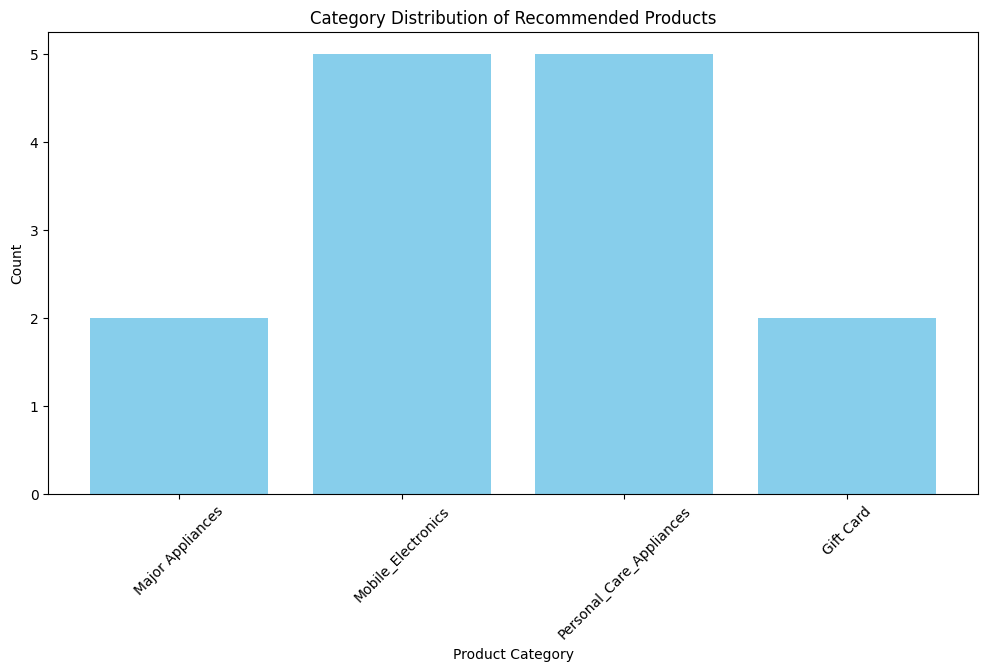

In [ ]:
recommended_product_ids = recommended_product_details.select('product_id_indexed')

recommended_with_category = recommended_product_ids.join(df_indexed, 'product_id_indexed').select('product_id_indexed', 'product_category')

category_counts = recommended_with_category.groupBy('product_category').count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(category_counts['product_category'], category_counts['count'], color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Category Distribution of Recommended Products')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import length

df = df.withColumn('review_length', length(df['review_body']))

df.stat.corr('review_length', 'star_rating')
df.stat.corr('review_length', 'helpful_votes')


0.2359119192067483

0.236 suggests a weak positive linear relationship between the length of a review and the number of helpful votes it receives. This means that longer reviews tend to receive slightly more helpful votes, but the correlation is not strong.

In [ ]:
import plotly.express as px

pdf = df.toPandas()
fig = px.bar(pdf.groupby('product_category')['star_rating'].mean().reset_index(),
             x='product_category', y='star_rating', title='Average Star Rating per Product Category')
fig.show()


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=["star_rating", "helpful_votes", "review_length"], outputCol="features")
df_assembled = assembler.transform(df)

kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(df_assembled)

predictions = model.transform(df_assembled)
predictions.show()


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+---------------+----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|review_length|       features|prediction|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-------------+---------------+----------+
|         US|   42489718| RJ7RSBCHUDNNE|B004LLIKVU|     473048287|amazon.com egift ...|       Gift Card|          5|            0|          0|   N|                Y|gift card for the...|it's an amazon gi...| 2015-08-3

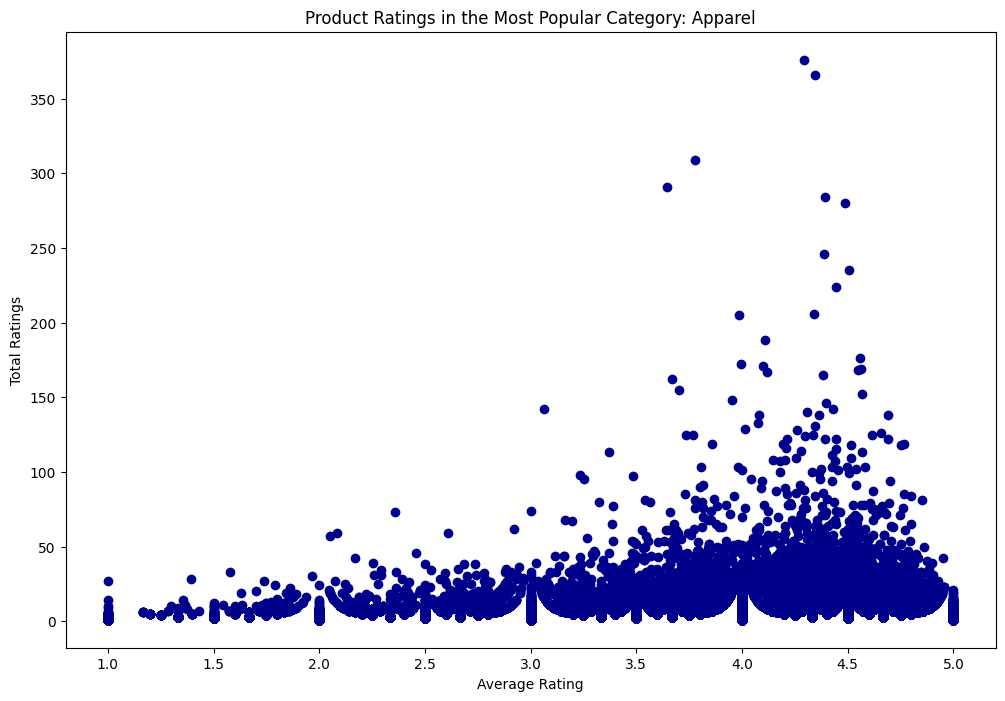

In [ ]:
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt

category_popularity = df.groupBy("product_category").count().orderBy("count", ascending=False)

top_category = category_popularity.first()

product_stats_top_category = df.filter(df.product_category == top_category['product_category']).groupBy('product_id').agg(
    avg('star_rating').alias('avg_rating'),
    count('star_rating').alias('total_ratings')
).toPandas()

plt.figure(figsize=(12, 8))
plt.scatter(product_stats_top_category['avg_rating'], product_stats_top_category['total_ratings'], color='darkblue')
plt.title(f'Product Ratings in the Most Popular Category: {top_category["product_category"]}')
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.show()


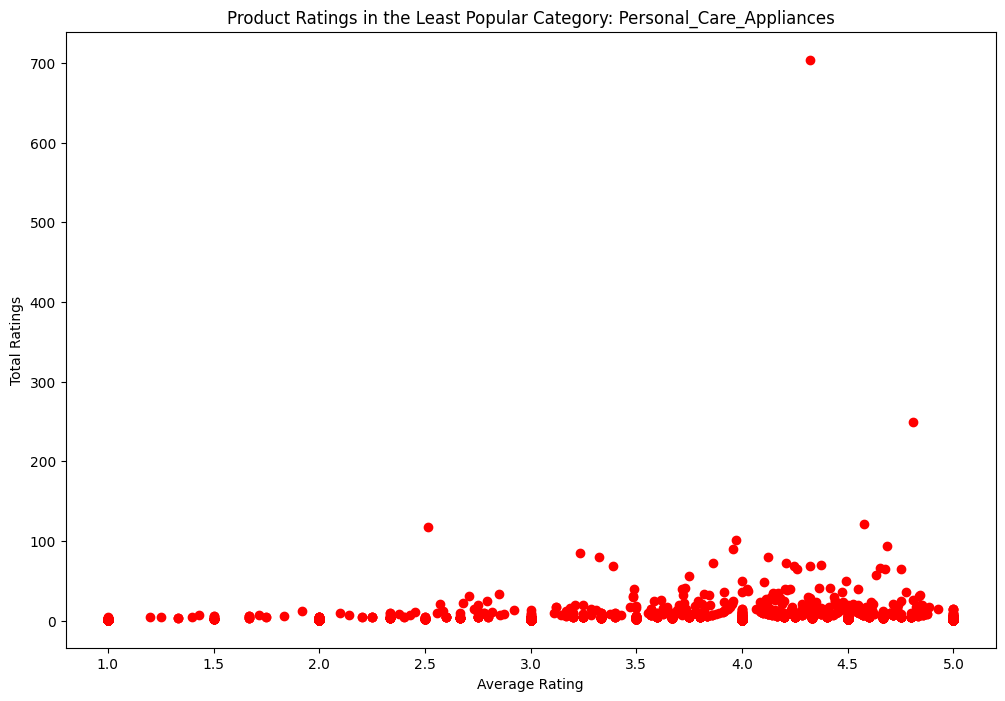

In [19]:
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt
category_popularity = df.groupBy("product_category").count().orderBy("count", ascending=False)

least_popular_category = category_popularity.orderBy("count", ascending=True).first()

product_stats_least_popular_category = df.filter(df.product_category == least_popular_category['product_category']).groupBy('product_id').agg(
    avg('star_rating').alias('avg_rating'),
    count('star_rating').alias('total_ratings')
).toPandas()

plt.figure(figsize=(12, 8))
plt.scatter(product_stats_least_popular_category['avg_rating'], product_stats_least_popular_category['total_ratings'], color='red')
plt.title(f'Product Ratings in the Least Popular Category: {least_popular_category["product_category"]}')
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.show()


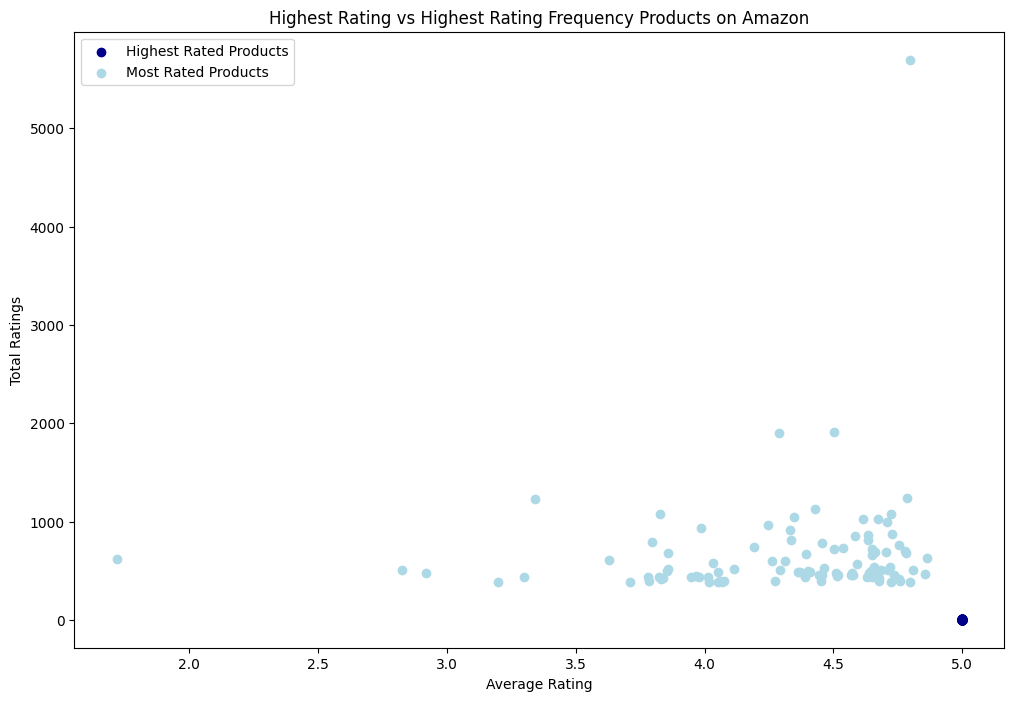

In [ ]:
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt  # Corrected import here

product_stats = df.groupBy('product_id').agg(
    avg('star_rating').alias('avg_rating'),
    count('star_rating').alias('total_ratings')
)

top_products = product_stats.orderBy('avg_rating', ascending=False).limit(100)
most_rated_products = product_stats.orderBy('total_ratings', ascending=False).limit(100)


top_products_pd = top_products.toPandas()
most_rated_products_pd = most_rated_products.toPandas()

plt.figure(figsize=(12, 8))
plt.scatter(top_products_pd['avg_rating'], top_products_pd['total_ratings'], color='darkblue', label='Highest Rated Products')
plt.scatter(most_rated_products_pd['avg_rating'], most_rated_products_pd['total_ratings'], color='lightblue', label='Most Rated Products')
plt.title('Highest Rating vs Highest Rating Frequency Products on Amazon')
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.legend()
plt.show()


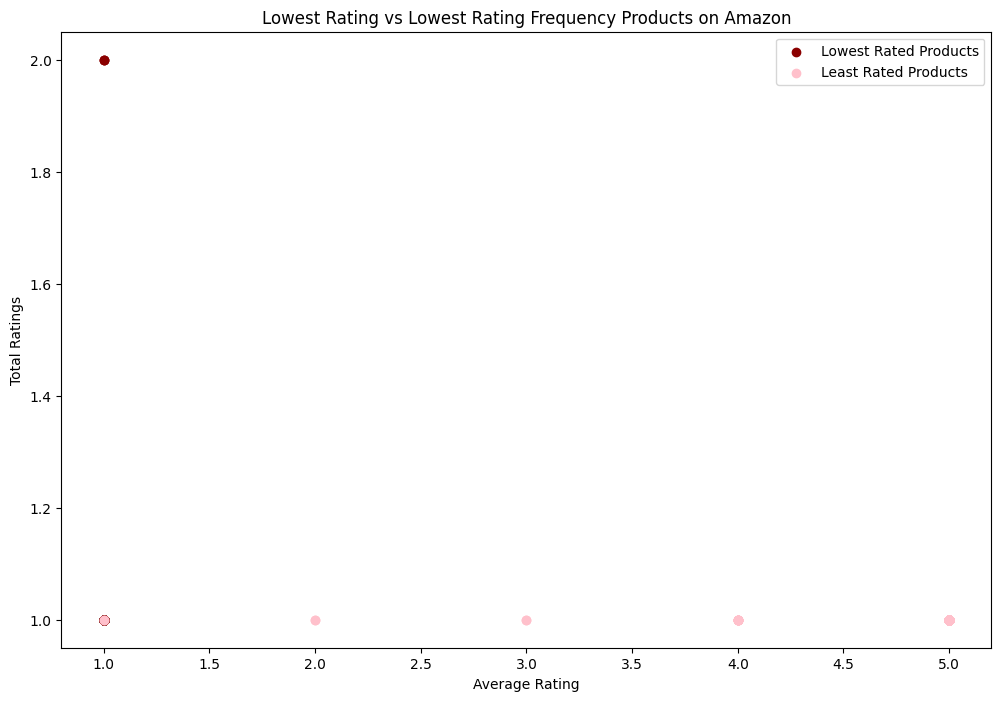

In [ ]:
from pyspark.sql.functions import avg, count

product_stats = df.groupBy('product_id').agg(
    avg('star_rating').alias('avg_rating'),
    count('star_rating').alias('total_ratings')
)

lowest_rated_products = product_stats.orderBy('avg_rating', ascending=True).limit(100)
least_rated_products = product_stats.orderBy('total_ratings', ascending=True).limit(100)


lowest_rated_products_pd = lowest_rated_products.toPandas()
least_rated_products_pd = least_rated_products.toPandas()


plt.figure(figsize=(12, 8))
plt.scatter(lowest_rated_products_pd['avg_rating'], lowest_rated_products_pd['total_ratings'], color='darkred', label='Lowest Rated Products')
plt.scatter(least_rated_products_pd['avg_rating'], least_rated_products_pd['total_ratings'], color='pink', label='Least Rated Products')
plt.title('Lowest Rating vs Lowest Rating Frequency Products on Amazon')
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.legend()
plt.show()

